In [1]:
!python -m pip install "sep_plot @ git+http://zapad.stanford.edu/bob/pySepPlot.git@2bffacb9fb36963339a0834c2b04a0aedff91db4"


  Using cached sep_plot-0.9.102-py2.py3-none-any.whl
  Using cached sep_python-0.9.78-py2.py3-none-any.whl
  Using cached genericsolver-1.0.7-py2.py3-none-any.whl


You should consider upgrading via the '/Users/bob/sep/bin/python -m pip install --upgrade pip' command.


In [1]:
import copy
import numpy as np
from sep_python.sep_vector import FloatVector,get_sep_vector
class boxFilter(FloatVector):
    """Class for defining a filter on a box"""
    def __init__(self,sh,mask,zero_lag,vals=None,space_only=False):
        """
        Create a filter that is a n-d cube with some of the fixed (probably zeroed
        
        sh   - N-d arry of shape
        zero_lag - Location of the zero lag in the filter
        
        mask - Mask for filter coefs n-d array (should be 0 or 1
        vals - Value for filter coeficients
        
        space_only - Whether or not actually have storage
        """
        if tuple(sh)!= mask.shape:
            raise Exception(f"Mask {mask.shape} and filter {sh} shape must be the same")
        
        if vals is not None:
            if vals.shape != sh:
                raise Exception("vals not the same shape")
        sh=np.asarray(sh)[::-1]
        hyper=Hypercube.set_with_ns(sh)
        super().__init__(hyper,vals=vals)    
        self.mask=copy.deepcopy(mask)   
        self.zeroL=np.asarray(zero_lag)
        
    @classmethod
    def PEF(self,sh,one_loc):
        if len(sh) != len(one_loc):
            raise Exception("One location is not the same size as box filter shape")
        b=1
        one_1d=0
        for filt_s, one_s in zip(reversed(sh),reversed(one_loc)):
            if one_s < 0 or one_s >= filt_s:
                raise Exception("Illegal locaiton for one in the filter")
            one_1d+=one_s*b
            b*=filt_s
        
        msk=np.ones(sh,dtype=np.float32)
        m=np.ravel(msk)
        vals=np.zeros(sh,dtype=np.float32)
        v=np.ravel(vals)
        v[:one_1d]=0
        m[:one_1d+1]=0
        v[one_1d]=1
        return boxFilter(sh,msk,one_loc,vals=vals)

                     
    def clone(self):
        """Return a clone of the helix filter"""
        x=boxFilter(self.get_nd_array().shape,self.mask,self.zeroL,vals=self.get_nd_array())
        return x
    
    def cloneSpace(self):
        x=boxFilter(self.get_nd_array().shape,self.mask,self.zeroL,space_only=True)
        return x


WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [2]:
import numba
from genericSolver.pyOperator import Operator
class convOpAdjData(Operator):
    def __init__(self,model,data,filt):
        if not model.checkSame(data) and not isinstance(model,FloatVector):
            raise Exception("Expecting model and data to be the same shape and float vectors")
        self.filt=filt.clone()
        
        if len(filt.get_nd_array().shape) >len(model.get_nd_array().shape):
            raise Exception("Filter must be same number of dimensions or smaller than model/data")
        super().__init__(model,data)
        
        
    
    def forward(self,add,model,data):
        self.checkDomainRange(model,data)
        if not add:
            data.zero()
        m=model.get_nd_array()
        d=data.get_nd_array()
        f=self.filt.get_nd_array()
        if len(m.shape)==2:
            if len(f.shape)==2:
                forward_2_2_m(m,f,d,self.filt.zeroL)
            else:
                forward_2_1_m(m,f,d,self.filt.zeroL)
        else:
            forward_1_1_m(m,f,d,self.filt.zeroL)
        
        
    
    def adjoint(self,add,model,data):
        self.checkDomainRange(model,data)
        if not add:
            model.zero()
        m=model.get_nd_array()
        d=data.get_nd_array() 
        f=self.filt.get_nd_array()
        
        if len(m.shape)==2:
            if len(f.shape)==2:
                adjoint_m_2_2(m,f,d,self.filt.zeroL)
            else:
                adjoint_m_2_1(m,f,d,self.filt.zeroL)
        else:
            adjoint_m_1_1(m,f,d,self.filt.zeroL)
        
class convOpAdjFilter(Operator):
    def __init__(self,filt,data,model):
        if not model.checkSame(data) and not isinstance(model,FloatVector):
            raise Exception("Expecting model and data to be the same shape and float vectors")
        self.model=copy.deepcopy(model)
        
        if len(filt.get_nd_array().shape) >len(model.get_nd_array().shape):
            raise Exception("Filter must be same number of dimensions or smaller than model/data")
        super().__init__(filt,data)
        
        
    
    def forward(self,add,filt,data):

        self.checkDomainRange(filt,data)
        if not add:
            data.zero()
        m=self.model.get_nd_array()
        d=data.get_nd_array()
        ftemp=filt.clone()
        f=ftemp.get_nd_array()
        f[:]=f[:]*filt.mask[:]

        if len(m.shape)==2:
            if len(f.shape)==2: 
               forward_2_2(m,f,d,filt.zeroL)
            else:
                forward_2_1(m,f,d,filt.zeroL)
        else:
            forward_1_1(m,f,d,filt.zeroL)
        
        
    def adjoint(self,add,filt,data):
        self.checkDomainRange(filt,data)
        if not add:
            filt.zero()
        m=self.model.get_nd_array()
        d=data.get_nd_array() 
        ftemp=filt.clone()
        f=ftemp.get_nd_array()
        ftemp.zero()
        if len(m.shape)==2:
            if len(f.shape)==2:
                adjoint_f_2_2(m,f,d,filt.zeroL)
            else:
                adjoint_f_2_1(m,f,d,filt.zeroL)
        else:
            adjoint_f_1_1(m,f,d,filt.zeroL)
        f[:]=f[:]*filt.mask[:]
        filt.scale_add(ftemp)
@numba.njit()
def forward_2_2_m(m ,f,d,zero): 
    for i2 in range(m.shape[0]):
        if i2 < zero[0] or i2 >m.shape[0]-zero[0]:
            d[i2,:]+=m[i2,:]
        else:
            for i1 in range(m.shape[1]):
                if i1<zero[1] or i1 > m.shape[1]-zero[1]:
                    d[i2,i1]+=m[i2,i1]
                else:
                    for if2 in range(0,f.shape[0]):
                        for if1 in range(0,f.shape[1]):
                            d[i2,i1]+=f[if2,if1]*m[i2-if2+zero[0] ,i1-if1+zero[1]]

    
@numba.njit()
def forward_2_1_m(m,f,d,zero):               
    for i2 in range(m.shape[0]):
        for i1 in range(m.shape[1]):
            if i1 < zero[0] or i1 >m.shape[0]-zero[0]:
                d[i2,i1]+=m[i2,i1]
            else:
                for if1 in range(0,f.shape[1]):
                    d[i2,i1]+=f[if1]*m[i2 ,i1-if1+zero[0]]
                                 
@numba.njit()
def forward_1_1_m(m,f,d,zero):
    for i1 in range(m.shape[0]):
        if i1 < zero[0] or i1 >m.shape[0]-zero[0]:
            d[i1]+=m[i1]
        else:
            for if1 in range(0,f.shape[1]):
                d[i1]+=f[if1]*m[i1-if1+zero[0]]
                
@numba.njit()
def forward_2_2(m,f,d,zero): 
    for i2 in range(f.shape[0]-zero[0]-1,m.shape[0]-zero[0]):
        for i1 in range(f.shape[1]-zero[1]-1,m.shape[1]-zero[1]):
            for if2 in range(0,f.shape[0]):
                for if1 in range(0,f.shape[1]):
                    d[i2,i1]+=f[if2,if1]*m[i2-if2+zero[0] ,i1-if1+zero[1]]

    
@numba.njit()
def forward_2_1(m,f,d,zero):               
    for i2 in range(m.shape):
        for i1 in range(f.shape[0]-zero[0]-1,m.shape[1]-zero[0]):
                for if1 in range(0,f.shape[1]):
                    d[i2,i1]+=f[if1]*m[i2 ,i1-if1+zero[0]]
                                 
@numba.njit()
def forward_1_1(m,f,d,zero):             
    for i1 in range(f.shape[0]-zero[0]-1,m.shape[0]-zero[0]):
            for if1 in range(0,f.shape[1]):
                d[i1]+=f[if1]*m[i1-if1+zero[0]]

@numba.njit()
def adjoint_m_2_2(m,f,d,zero):          
    for i2 in range(m.shape[0]):
        if i2 < zero[0] or i2 >m.shape[0]-zero[0]:
            m[i2,:]+=d[i2,:]
        else:
            for i1 in range(m.shape[1]):
                if i1<zero[1] or i1 > m.shape[1]-zero[1]:
                    m[i2,i1]+=d[i2,i1]
                else:
                    for if2 in range(0,f.shape[0]):
                        for if1 in range(0,f.shape[1]):
                            m[i2-if2+zero[0] ,i1-if1+zero[1]]+=d[i2,i1]*f[if2,if1]

@numba.njit()
def adjoint_m_2_1(m,f,d,zero):  
    for i2 in range(m.shape[0]):
        for i1 in range(m.shape[1]):
            if i1 < zero[0] or i1 >m.shape[0]-zero[0]:
                m[i2,i1]+=d[i2,i1]
            else:
                for if1 in range(0,f.shape[0]):
                    m[i2,i1-if1+zero[1]]+=d[i2,i1]*f[if1]
  
@numba.njit()
def adjoint_m_1_1(m,f,d,zero):
    for i1 in range(m.shape[0]):
        if i1 < zero[0] or i1 >m.shape[0]-zero[0]:
            m[i1]+=d[i1]
        else:
            for if1 in range(0,f.shape[0]):
                m[i1-if1+zero[1]]+=d[i1]*f[if1]
                
@numba.njit()
def adjoint_f_2_2(m,f,d,zero):    

    for i2 in range(f.shape[0]-zero[0]-1,m.shape[0]-zero[0]):
        for i1 in range(f.shape[1]-zero[1]-1,m.shape[1]-zero[1]):
            for if2 in range(0,f.shape[0]):
                for if1 in range(0,f.shape[1]):
                    f[if2,if1]+=m[i2-if2+zero[0] ,i1-if1+zero[1]]*d[i2,i1]
@numba.njit()
def adjoint_f_2_1(m,f,d,zero):  
    for i2 in range(m.shape[0]):
        for i1 in range(f.shape[0]-zero[0]-1,m.shape[1]-zero[0]):
                for if1 in range(0,f.shape[0]):
                    f[if1]+=m[i2,i1-if1+zero[1]]*d[i2,i1]
  
@numba.njit()
def adjoint_f_1_1(m,f,d,zero):
    for i1 in range(f.shape[0]-zero[0]-1,m.shape[0]-zero[0]):
            for if1 in range(0,f.shape[0]):              
                f[if1]+=m[i1-if1+zero[1]]*d[i1]

In [3]:
class weight_op(Operator):
    def __init__(self,model,data,wt):
        w=np.copy(wt)
        self._wt=w.ravel()
        super().__init__(model,data)
    
    def forward(self,add,model,data):
        self.checkDomainRange(model,data)
        if not add:
            data.zero()
        d2=data.get_nd_array()
        d=d2.ravel()
        m2=model.get_nd_array()
        m=m2.ravel()
        d[:]=d[:]+m[:]*self._wt[:]
    def adjoint(self,add,model,data):
        self.checkDomainRange(model,data)
        if not add:
            model.zero()
        d2=data.get_nd_array()
        d=d2.ravel()
        m2=model.get_nd_array()
        m=m2.ravel()
        m[:]=m[:]+d[:]*self._wt[:]      


In [10]:
from genericSolver.pyProblem import ProblemL2Linear,ProblemL2LinearReg
from genericSolver.pyLinearSolver import LCGsolver
from genericSolver.pyStopper import BasicStopper
from genericSolver.pyOperator import ChainOperator
from sep_plot import Grey



@numba.njit()
def find_zeros_2d(sh,zero,m,wt):
    for i2 in range(sh[0]-zero[0]-1,m.shape[0]-zero[0]):
        for i1 in range(sh[1]-zero[1]-1,m.shape[1]-zero[1]):
            haveZero=False
            for if2 in range(0,sh[0]):
                for if1 in range(0,sh[1]):
                    if m[i2-if2+zero[0] ,i1-if1+zero[1]]==0.:
                        haveZero=False
            wt[i2,i1]=1



            
def findPef(model,sh,zero):
    filt=boxFilter.PEF(sh,zero)
    data=model.clone()
    wtVec=data.clone()
    wtVec.zero()
    find_zeros_2d(sh,zero,model.get_nd_array(),wtVec.get_nd_array())
    wt=weight_op(model,model,wtVec.get_nd_array())
    op=convOpAdjFilter(filt,data,data)
    data.scale(-1.)
    data.get_nd_array()[:,:]=np.multiply(data.get_nd_array(),wtVec.get_nd_array())
    wt_op=ChainOperator(op,wt)
    prob=ProblemL2Linear(filt,data,wt_op)
    stop=BasicStopper(niter=1000)
    solve=LCGsolver(stop)
    solve.run(prob,verbose=True)
    return prob.model

In [5]:
!wget https://raw.githubusercontent.com/rgclapp007/gp211-class-notebooks/main/data/seabin.HH

--2023-03-13 13:32:45--  https://raw.githubusercontent.com/rgclapp007/gp211-class-notebooks/main/data/seabin.HH
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103724 (101K) [application/octet-stream]
Saving to: ‘seabin.HH.3’

seabin.HH.3         100%[===================>] 101.29K  --.-KB/s    in 0.04s   

2023-03-13 13:32:46 (2.64 MB/s) - ‘seabin.HH.3’ saved [103724/103724]



in one
what is the bug now (25600,) 0 25600 25600


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
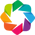

:Image   [x,y]   (z)

In [ ]:
import sep_python.modes
import numpy as np
from sep_python.hypercube import Hypercube
from sep_python.sep_vector import FloatVector
io=sep_python.modes.default_io
vec=io.vector_from_storage("seabin.HH")
import holoviews as hv
hv.extension('bokeh','matplotlib')
Grey(vec)

In [16]:
sh=(5,9)
zero=(0,3)
pef=findPef(vec,sh,zero)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2023-03-13T13-42-03.964351/
	Modeling Operator:		Ope*Oper
##########################################################################################

iter = 0000, obj = 4.20979e+02, resnorm = 2.90e+01, gradnorm = 3.56e+03, feval = 2
iter = 0001, obj = 1.23603e+02, resnorm = 1.57e+01, gradnorm = 5.00e+02, feval = 4
iter = 0002, obj = 8.43181e+01, resnorm = 1.30e+01, gradnorm = 3.52e+02, feval = 6
iter = 0003, obj = 5.77888e+01, resnorm = 1.08e+01, gradnorm = 1.30e+02, feval = 8
iter = 0004, obj = 4.85562e+01, resnorm = 9.85e+00, gradnorm = 8.08e+01, feval = 10
iter = 0005, obj = 4.15906e+01, resnorm = 9.12e+00, gradnorm = 4.45e+01, feval = 12
iter = 0006, obj = 3.89388e+01, resnorm = 8.82e+00, gradnorm = 6.20e+01, feval = 14
iter = 0007, obj = 3.88236e+01, resnorm = 8.81e+00, gradnorm = 3.17e+01, feval = 16
iter = 0008, obj = 3.76

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
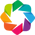

:Image   [x,y]   (z)

In [17]:
import holoviews as hv
hv.extension('bokeh','matplotlib')
known=vec.clone()
@numba.njit()
def known_data(vec,known):
    for i2 in range(vec.shape[0]):
        for i1 in range(vec.shape[1]):
            if vec[i2,i1]==0:
                known[i2,i1]=0
            else:
                known[i2,i1]=1
known_data(vec.get_nd_array(),known.get_nd_array())

Grey(known)

In [26]:


j_op=weight_op(vec,vec,known.get_nd_array())
problemStop=BasicStopper(niter=500)
data=vec.clone()
d=data.get_nd_array()

model=data.clone()
reg=convOpAdjData(model,data,pef)
eps=1000

problemconv=ProblemL2LinearReg(model,data,j_op,eps,reg_op=reg)
solve_base=LCGsolver(problemStop)
solve_base.run(problemconv)

Grey(problemconv.model,pclip=99)+Grey(data,pclip=100)

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

In [20]:
x=vec.clone()
reg_1.forward(False,vec,x)
Grey(x)

NameError: name 'reg_1' is not defined

In [21]:
from sep_plot import Graph
Graph(vec.get_nd_array()[0,:])

:Overlay
   .Curve.A_0 :Curve   [x]   (y)

In [22]:
class randomRes(ProblemL2LinearReg):
    """Linear inverse problem regularized of the form 1/2*|Lm-d|_2 + epsilon^2/2*|Am-m_prior|_2"""

    def __init__(
        self,
        model,
        data,
        op,
        epsilon,
        randLevel=.6,
        grad_mask=None,
        reg_op=None,
        prior_model=None,
        prec=None,
        minBound=None,
        maxBound=None,
        boundProj=None,
        
    ):
        super().__init__( model,data,op,epsilon,grad_mask,reg_op,prior_model,prec,minBound,maxBound,boundProj)
        self.rnd=self.res.vecs[1].clone()
        x=self.rnd.get_nd_array().ravel()
        x[:]=np.random.normal(0,randLevel,size=(self.rnd.get_hyper().get_n123()))
    def resf(self, model):
        """Method to return residual vector r = [r_d; r_m]: r_d = Lm - d; r_m = epsilon * (Am - m_prior)"""
        if model.norm() != 0.0:
            self.op.forward(False, model, self.res)
        else:
            self.res.zero()
        # Computing r_d = Lm - d
        self.res.vecs[0].scaleAdd(self.data, 1.0, -1.0)
        self.res.vecs[1].scaleAdd(self.rnd,1,-1.)
        # Computing r_m = Am - m_prior
        if self.prior_model is not None:
            self.res.vecs[1].scaleAdd(self.prior_model, 1.0, -1.0)
        # Scaling by epsilon epsilon*r_m
        self.res.vecs[1].scale(self.epsilon)
        return self.res

In [28]:
problemStop=BasicStopper(niter=400)
eps=1000

model.zero()
model=data.clone()
reg=convOpAdjData(model,data,pef)
problemconv2=randomRes(model,data,j_op,eps,randLevel=.07,reg_op=reg)
solve_base=LCGsolver(problemStop)
print(problemconv2.res.vecs[1].get_nd_array()[0,:10])
solve_base.run(problemconv2)

Grey(problemconv2.model,pclip=99)+Grey(data,pclip=100)+Grey(problemconv2.res.vecs[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)

In [24]:
vecs=[]
for i in range(9):
    reg=convOpAdjData(model,data,pef)
    problemconv2=randomRes(model,data,j_op,eps,randLevel=.07,reg_op=reg)
    solve_base=LCGsolver(problemStop)
    solve_base.run(problemconv2)
    vecs.append(problemconv2.model.clone())


In [25]:
def plot_result_reg(item):
    return Grey(vecs[item])
# When run live, this cell's output should match the behavior of the GIF below
dmap = hv.DynamicMap(plot_result_reg, kdims=['iter'])
dmap.redim.range(iter=(0,len(vecs)))

Traceback (most recent call last): 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/plotting/util.py", line 280, in get_plot_frame 
 return map_obj[key] 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 1213, in __getitem__ 
 val = self._execute_callback(*tuple_key) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 980, in _execute_callback 
 retval = self.callback(*args, **kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 580, in __call__ 
 ret = self.callable(*args, **kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/util/__init__.py", line 1010, in dynamic_operation 
 key, obj = resolve(key, kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/util/__init__.py", line 999, in resolve 
 return key, map_obj[key] 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 1213, in __getitem__ 
 val = self._execute_callback(*tuple_key) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 980, in _execute_callback 
 retval = self.callback(*args, **kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 580, in __call__ 
 ret = self.callable(*args, **kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/util/__init__.py", line 1010, in dynamic_operation 
 key, obj = resolve(key, kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/util/__init__.py", line 999, in resolve 
 return key, map_obj[key] 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 1213, in __getitem__ 
 val = self._execute_callback(*tuple_key) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 980, in _execute_callback 
 retval = self.callback(*args, **kwargs) 
 File "/Users/bob/sep/lib/python3.9/site-packages/holoviews/core/spaces.py", line 580, in __call__ 
 ret = self.callable(*args, **kwargs) 
 File "/var/folders/mp/l0m5x3y53mn76hxpkm918xrr0000gn/T/ipykernel_86357/2318833352.py", line 2, in plot_result_reg 
 return Grey(vecs[item]) 
IndexError: list index out of range

:DynamicMap   [iter]
   :Image   [x,y]   (z)